In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models, utils
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.utils import to_categorical  # Correctly importing to_categorical
from ucimlrepo import fetch_ucirepo

In [2]:
# Fetch dataset
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)

# Data as pandas dataframes
X = optical_recognition_of_handwritten_digits.data.features
y = optical_recognition_of_handwritten_digits.data.targets

# Metadata
print(optical_recognition_of_handwritten_digits.metadata)

# Variable information
print(optical_recognition_of_handwritten_digits.variables)

# Optionally, print some information about the data
print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Unique digits in target:", np.unique(y))

{'uci_id': 80, 'name': 'Optical Recognition of Handwritten Digits', 'repository_url': 'https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits', 'data_url': 'https://archive.ics.uci.edu/static/public/80/data.csv', 'abstract': 'Two versions of this database available; see folder', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 5620, 'num_features': 64, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C50P49', 'creators': ['E. Alpaydin', 'C. Kaynak'], 'intro_paper': {'title': 'Methods of Combining Multiple Classifiers and Their Applications to Handwritten Digit Recognition', 'authors': 'C. Kaynak', 'published_in': 'MSc Thesis, Institute of Graduate Studies in Science and Engineering, Bogazici University', 

In [3]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [4]:
# Convert features and labels to numpy arrays (if they are not already)
X = np.array(X)
y = np.array(y)

# Reshape X to fit the model input shape: (n_samples, 8, 8, 1)
X = X.reshape(-1, 8, 8, 1)

# Normalize the feature data
X = X.astype('float32') / 16  # Assuming pixel values range from 0 to 16

# One-hot encode the target labels
y = to_categorical(y, num_classes=10)

In [5]:
# Initialize lists to store test labels and predictions
y_true = []
y_pred = []
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_no = 1

for train, test in kf.split(X):
    print(f'Training fold {fold_no}...')
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(X[train], y[train],
                        batch_size=32,
                        epochs=10,
                        verbose=1,
                        validation_data=(X[test], y[test]))
    
    # Append loss and accuracy
    all_train_loss.extend(history.history['loss'])
    all_val_loss.extend(history.history['val_loss'])
    all_train_acc.extend(history.history['accuracy'])
    all_val_acc.extend(history.history['val_accuracy'])
    
    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # Predict on the test data
    predictions = model.predict(X[test], batch_size=32)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(y[test], axis=1))
    
    fold_no += 1

Training fold 1...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
141/141 [==============================] - 1s 3ms/step - loss: 1.4540 - accuracy: 0.5347 - val_loss: 0.3917 - val_accuracy: 0.9128
Epoch 2/10
141/141 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.8648 - val_loss: 0.2316 - val_accuracy: 0.9288
Epoch 3/10
141/141 [==============================] - 0s 2ms/step - loss: 0.3113 - accuracy: 0.9070 - val_loss: 0.1645 - val_accuracy: 0.9466
Epoch 4/10
141/141 [==============================] - 0s 2ms/step - loss: 0.2383 - accuracy: 0.9315 - val_loss: 0.1366 - val_accuracy: 0.9573
Epoch 5/10
141/141 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9464 - val_loss: 0.1118 - val_accuracy: 0.9671
Epoch 6/10
141/141 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9475 - val_loss: 0.1018 - val_accuracy: 0.9751
Epoch 7/10
141/141 [============

Confusion Matrix:
[[552   0   0   0   1   0   1   0   0   0]
 [  0 564   2   0   0   0   0   1   3   1]
 [  0   0 556   0   1   0   0   0   0   0]
 [  0   0   2 562   0   5   0   0   1   2]
 [  0   0   0   0 559   0   5   0   0   4]
 [  0   0   0   2   1 549   0   0   1   5]
 [  0   1   0   0   2   0 554   0   1   0]
 [  0   0   0   1   0   0   0 565   0   0]
 [  1   1   0   1   0   1   0   0 548   2]
 [  0   1   0   4   2   3   0   3   1 548]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       554
           1       0.99      0.99      0.99       571
           2       0.99      1.00      1.00       557
           3       0.99      0.98      0.98       572
           4       0.99      0.98      0.99       568
           5       0.98      0.98      0.98       558
           6       0.99      0.99      0.99       558
           7       0.99      1.00      1.00       566
           8       0.99      0.99      0.

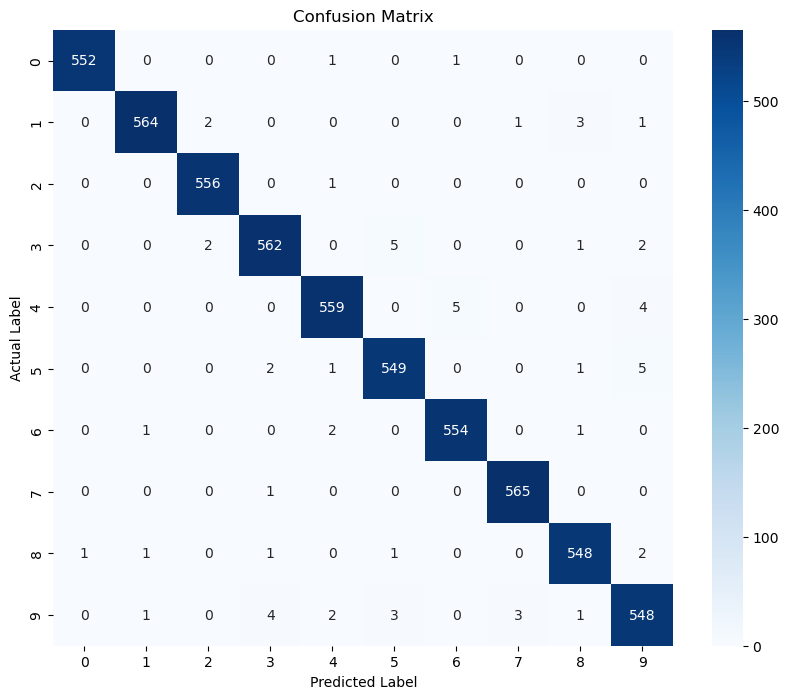

Average Loss: 0.04553227401338518
Average Accuracy: 98.61743795871735%


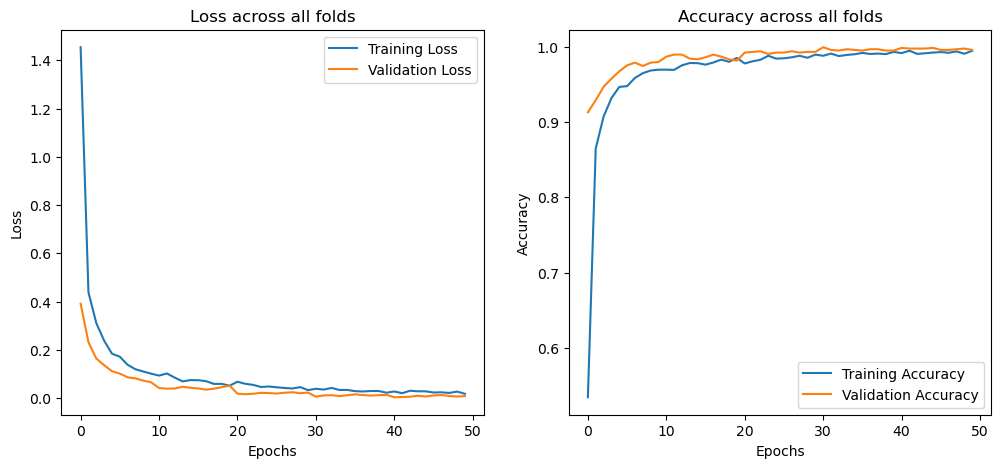

In [6]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate average loss and accuracy
average_loss = np.mean(all_val_loss)
average_accuracy = np.mean(all_val_acc) * 100

print(f'Average Loss: {average_loss}')
print(f'Average Accuracy: {average_accuracy}%')

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.title('Loss across all folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(all_train_acc, label='Training Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.title('Accuracy across all folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()